# Part 3: MLP

We extend the single token model to include more context into the model.
We will also extend the representation of tokens into embedding space. This will allow the network to learn more novel connections between similar embeddings (e.g. dog and cat are both animals and might be similar).
We follow the approaches by [Bengio et.al 2009].

#### Imports and data loading

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r', encoding='utf-8').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


#### Setup dataset with context offset

__Notes__:
* __Blocksize__: How many characters are used to predict the next one

First, we setup the training and test set with a blocksize of 3 characters. This means, each label has
3 characters before it as training data. For starts, we only use the first 5 words to make calulation fast
to show the process:

In [6]:
block_size = 3 # Offset of context
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [7]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([32, 3]), torch.Size([32]), torch.int64, torch.int64)

#### Creating the embedding layer

__Notes__:

* __Split tensor along a dimension__: For this we can use __torch.unbind__, which returns a tuple of
tensor slices along a given dimension.
* __Concat tensor slices__: We can use __torch.cat__ along a dimension for a sequence of tensors for this.
* __Efficient way of manipulating a tensor shape__: We can use __torch.view__ to extremely efficiently manipulate the shape of
a tensor. This is because the storage is not manipulated, just the representation.
* __Dimension inferring in view__: We can use -1 as dimension value to let torch infer the dimension from the data!
* __Tensor storage__: Tensors are represented as 1-dimensional lists in the memory, which are just represented by views with strides, offsets, ...

First, for each of the characters we want a representation of size 2.
This means, with a blocksize of 3, we (later on) get a representation of size 6 for
our character context:

In [8]:
C = torch.randn((27, 2))

Because of the nice indexing of PyTorch (similar to numpy's indexing), we can do the following to
get the embeddings for all of X at once:

In [9]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Next we create random weights and biases for our embedding layer.
The input size is 3x2 (3 characters with a 2 dim embedding each) by 100 (hyperparameter for emb. size):

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

#### Inefficient way of manipulating the input to fit the layer input size:

Next, we have to find a way to concatenate the input tensor X to fit the matrix multiplication
requirements with W1. For this, we use the torch.cat function to concatenate a sequence
of tensors along dimension 1 (since we want 2+2+2 as our dim=1). Since we need a sequence of
the dimensions we want to cat along, we can use torch.unbind along the first dimension of the
emb tensor, which returns a tuple of the slices:

In [11]:
slow_emb = torch.cat(torch.unbind(emb, dim=1), dim=1)

#### Efficient way to generate input
We now propose a more efficient way of generating the input: by using __views__.
This does just give a different return from memory, but does not change anything in memory,
making it very fast!

In [12]:
fast_emb = emb.view(32,6)

We can now prove this does the same:

In [13]:
slow_emb == fast_emb

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

#### Fast way of creating the hidden layer for the embeddings

Thus, we can create our hidden states between input and embedding layers as follows
using view and matrix multiplication, as well as tanh as activation function:

In [14]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [15]:
h

tensor([[ 0.9851, -0.7448,  0.4785,  ...,  0.6980, -0.9932,  0.6045],
        [ 0.5811,  0.9712, -0.8279,  ...,  0.8543, -0.9382, -0.8643],
        [ 0.9989, -0.9998,  0.9938,  ..., -0.9902, -0.9958,  1.0000],
        ...,
        [ 1.0000, -0.9756,  0.6907,  ...,  0.9995, -1.0000, -0.5075],
        [-0.6624,  0.9996, -0.9860,  ...,  0.6559, -0.9984, -0.8874],
        [ 0.9902, -0.9999,  0.9969,  ..., -0.9316, -0.9525,  0.9997]])

In [16]:
h.shape

torch.Size([32, 100])

### Creating the second hidden layer (output)

First, we create a layer with an input dim of 100 (emb size) and an output size
of 27 (num characters we want probabilities for):

In [17]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [18]:
logits = h @ W2 + b2

In [19]:
logits.shape

torch.Size([32, 27])

We then manually apply a softmax function, like in the simple bigram examples before:

In [20]:
counts = logits.exp()

In [21]:
prob = counts / counts.sum(1, keepdims=True)

In [22]:
prob.shape

torch.Size([32, 27])

### Get the loss (like in last exercises)

We calculate the average neg. log-likelihood loss for the labels Y:

In [23]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(13.0840)

## Putting all of it together neatly

__Notes__:
* __Never re-implement your own loss function if it exists in torch!__: PyTorch does make the computation __more performant__ using __kernels__ for forward and backward pass!
Also solves some issues with outliers in the logits (ae. large positive values) that then exeeds the range of the floating point type used.
__PyTorch solves this internally by subtracting the maximum value from the logits__, which does not change the output!
* __Logits + Softmax ==> Cross_entropy__: We can just pass the logits to the function API cross_entropy function to get
the same results!

In [24]:
g = torch.Generator().manual_seed(21474783647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [25]:
sum(p.nelement() for p in parameters)

3481

We also re-initialize X and Y to use the whole dataset:

In [26]:
block_size = 3 # Offset of context
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

#### Training loop
We now implement a training loop and optimize
To improve performance we also implement __mini-batching__.

__Notes__:

* __Intrinsic motivation of using Mini-Batches__: Is a trade-off between performance and a noisy gradient. We don't get the exact gradient of each sample, but
one that is __good enough__. Since we get __lots of performance__ this is a worth trade-off every time!
* __How to find a good learning rate (without employing gridsearch/random-seach which are BETTER IN PRODUCTION!!!!)__:
__==> In PROD USE GRID/RANDOM-SEARCH__
    1. Start of by finding a place where the learning rate starts to explode. For us, this seems to be outside of the range
[0.01, 1].
  2. We can then generate a bunch of learning rates (zb. 1000) on the log scale (using linspace and 10 ** lr).
  3. We then run a training loop with 1000 steps, switching lr for each iteration and collect the losses for each lr.
  4. The resulting losses can then be plotted against the learning rates we tried.


In [27]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [28]:
n_steps = 1000
batch_size = 32

lri = []
lri_losses = []

for i in range(n_steps):
    # Create a minibatch from X
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # FORWARD PASS
    # Emb layer
    emb = C[X[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
    # Output layer
    logits = h @ W2 + b2 # 32, 27
    # Loss
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # BACKWARD PASS
    lr = lrs[i]
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

    # track lr stats
    lri.append(lre[i])
    lri_losses.append(loss.item())

15.875308990478516
15.825887680053711
18.426513671875
14.21733570098877
18.271331787109375
18.176328659057617
16.647254943847656
18.76511001586914
16.355249404907227
18.10293197631836
17.08315086364746
18.21858787536621
15.194869995117188
16.841022491455078
17.94376564025879
13.557910919189453
15.801590919494629
15.624237060546875
15.211970329284668
20.366180419921875
15.779664039611816
18.560518264770508
15.526995658874512
20.63199806213379
15.404668807983398
14.307439804077148
17.6911563873291
16.507753372192383
15.289091110229492
15.753973960876465
15.673746109008789
16.052146911621094
17.000059127807617
16.54884147644043
16.361419677734375
17.877544403076172
17.956506729125977
16.456993103027344
13.444775581359863
14.90052318572998
16.664926528930664
17.618576049804688
14.982379913330078
15.415900230407715
17.57268524169922
14.727627754211426
15.126505851745605
17.44561195373535
18.878625869750977
17.983726501464844
15.374213218688965
15.123353958129883
11.678668022155762
17.844469

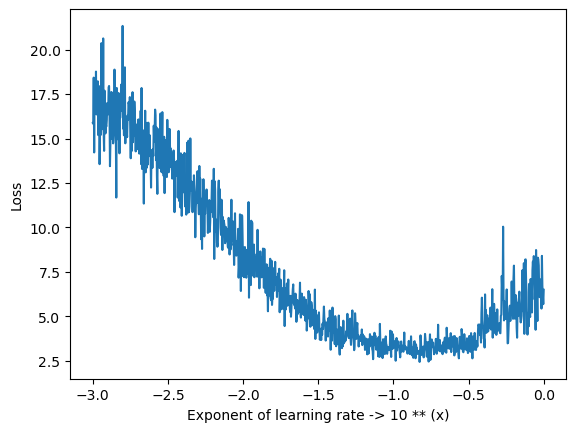

In [29]:
plt.plot(lri, lri_losses)
plt.xlabel('Exponent of learning rate -> 10 ** (x)')
plt.ylabel('Loss');

We can then just use the minimum of this evaluation as our learning rate.
Here, we see that 10 ** -1 is a good, value, which is 0.1.
(Note to reset the weights before running this again!)
We run this a bunch of times, decreasing the learning rate as we go on:

In [30]:
n_steps = 10000
batch_size = 32

lri = []
lri_losses = []

for i in range(n_steps):
    # Create a minibatch from X
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # FORWARD PASS
    # Emb layer
    emb = C[X[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
    # Output layer
    logits = h @ W2 + b2 # 32, 27
    # Loss
    loss = F.cross_entropy(logits, Y[ix])

    # BACKWARD PASS
    lr = 0.1
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

Evaluate loss on the whole training set:

In [31]:
emb = C[X] # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
# Output layer
logits = h @ W2 + b2 # 32, 27
# Loss
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4229, grad_fn=<NllLossBackward0>)

### Conclusion

__Things left out due to being known in detail already__:
* Train/Dev/Test splits
* Experimenting with larger layers: Scaling up embedding layer does not sufficiently increase loss -> Must be the dimension of the embeddings (2 is too small)
Andrej scales it up to a dimension of 30 with an embedding layer size of 300.